# **TR-2023/05 - Technical report: DBSCAN, Campinas, Brazil Groundwater Hydrochemical Dataset 2019**

|Technical Report ID  |2023/06|
|--|--|
| Title |Construction of Study Dataset|
| Authors | Diego Xavier Machado, Paula Dornhofer, Ana Elisa Abreu|
| Creation Date| 2023 - 06|


# Objetivo do Notebook
Esse notebook tem como objetivo dividir a base de dados das coletas feitas pelo Instituto de Geociências da Unicamp (IG) com base na data em que as coletas foram feitas e aplicar o algoritmo *Density-based spatial clustering of applications with noise* (DBSCAN) para obter grupos de poços relativamente semelhantes com base nos dados fornecidos. Para isso, é necessário que a base de dados das coletas esteja tratada.

In [ ]:
#-----------------------------------------------------#
#              IMPORTAÇÃO DAS BIBIOTECAS              #
#-----------------------------------------------------#

!pip install kneed
!pip install pyproj
!pip install folium
!pip install git+https://github.com/IanAguiar-ai/metrics.git

from pyproj import Proj
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from random import seed, random
from mutual_information import metrics as mtr

  Cloning https://github.com/IanAguiar-ai/metrics.git to /tmp/pip-req-build-r73fi0rm
  Running command git clone --filter=blob:none --quiet https://github.com/IanAguiar-ai/metrics.git /tmp/pip-req-build-r73fi0rm
  Resolved https://github.com/IanAguiar-ai/metrics.git to commit 452d14433fbfdb08a40602b9f8512873c129157e
  Preparing metadata (setup.py) ... done
  Created wheel for metrics: filename=metrics-0.0.12-py3-none-any.whl size=17646 sha256=edd895fd0829cb0433af55a01d013a7c535b25c608631c1686074d38af693d3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-p6f1e41o/wheels/c7/48/53/4f50b27b511fdefedb30381ad08615e2dc2bae6ab5a0986841
Successfully built metrics


# Importação dos arquivos
Para esse notebook, será necessário apenas o arquivo da base de dados das coletas, de forma já tratada, em arquivo `.csv`.

In [ ]:
#-----------------------------------------------------#
#               IMPORTAÇÃO DOS ARQUIVOS               #
#-----------------------------------------------------#

from google.colab import drive
drive.mount('/content/drive')

# df = Base de dados
df = pd.read_csv('/content/drive/Shareddrives/datasci4water/IG/data/interim/df_final.csv')
df = df.reset_index(drop=True)

Mounted at /content/drive


# Separação da base de dados principal de acordo com a data:
Com a base de dados principal, será criado duas outras novas base de dados. Uma para cada período de coleta. Portanto a data é a variável responsável por essa divisão. Assim, formam-se, bases de dados para os seguintes períodos:


*   Abril de 2019
*   Outubro de 2019



In [ ]:
#-----------------------------------------------------#
#         SEPARAÇÃO DA BASE DE DADOS POR DATA         #
#-----------------------------------------------------#

# Fazer a separação por data
df_abril = df.loc[df['date'] == '2019/04']
df_outubro = df.loc[df['date'] == '2019/10']


# Padronização dos valores
Como a base de dados possuem valores não numéricos referentes ao poço da amostra (coluna "*well*") e referente a data da coleta (coluna "*date*"), faremos a separação apenas dos valores numéricos para que o trabalho do algoritmo de aprendizado de máquina seja apenas sobre esses valores numéricos.

Ademais, como os valores possuem uma grande diferença entre ordens de grandeza, será feito a padronização desses valores, mantendo-os na mesma escala. Dessa  forma, pode-se evitar que variáveis com altas ordens de grandeza implique no cálculo de grandes distâncias entre os dados e influencie negativamente o funcionamento do algoritmo *K-Means*.

In [ ]:
#-----------------------------------------------------#
#               PADRONIZAÇÃO DOS VALORES              #
#-----------------------------------------------------#

#  Separação dos valores numéricos
df_abril_values = df_abril.iloc[:, 2:df_abril.shape[1]]
df_outubro_values = df_outubro.iloc[:, 2:df_outubro.shape[1]]

# Padronização dos vallores propriamente dito
df_scaler = StandardScaler()
df_abril_values = df_scaler.fit_transform(df_abril_values)
df_outubro_values = df_scaler.fit_transform(df_outubro_values)

# Mudança no sistema de coordenadas
As coordenadas no Dataframe estão no sistema UTM. Para a utilização da biblioteca *folium* no qual serão impressos os rótulos do agrupamento, as coordenadas devem estar no sistema de graus decimais. Para isso, faz-se a conversão dos valores


In [ ]:
#-----------------------------------------------------#
#                MUDANÇA DE COORDENADAS               #
#-----------------------------------------------------#

def utm_para_graus_decimais(easting, northing, lista_coordenadas):
    zona = 23
    hemisferio = 'S'
    proj = Proj(proj='utm', zone=zona, south=True, ellps='WGS84')
    longitude, latitude = proj(easting, northing, inverse=True)
    lista_coordenadas.append([latitude, longitude])


coordenadas_abril = []
coordenadas_outubro = []

for i in range(df_abril.shape[0]):
  utm_n = df_abril.iloc[i, 48]
  utm_e = df_abril.iloc[i, 47]
  utm_para_graus_decimais(utm_e, utm_n, coordenadas_abril)

for i in range(df_outubro.shape[0]):
  utm_n = df_outubro.iloc[i, 48]
  utm_e = df_outubro.iloc[i, 47]
  utm_para_graus_decimais(utm_e, utm_n, coordenadas_outubro)

## Métricas de Abril

In [ ]:
clusters_list_abril = []
for eps in range(6, 11):
  dbscan = DBSCAN(eps=eps, min_samples=1)
  dbscan.fit(df_abril_values)
  rotulos = dbscan.labels_
  clusters_list_abril.append(rotulos)
clusters_list_abril = np.array(clusters_list_abril)
clusters_list_abril

array([[0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 3, 4, 4, 0, 5, 0, 6, 7, 8],
       [0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 5],
       [0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 5],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3]])

In [ ]:
clusters_list_abril = [clusters_list_abril[0], clusters_list_abril[1], clusters_list_abril[3], clusters_list_abril[4]]
clusters_list_abril

[array([0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 3, 4, 4, 0, 5, 0, 6, 7, 8]),
 array([0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 5]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3])]

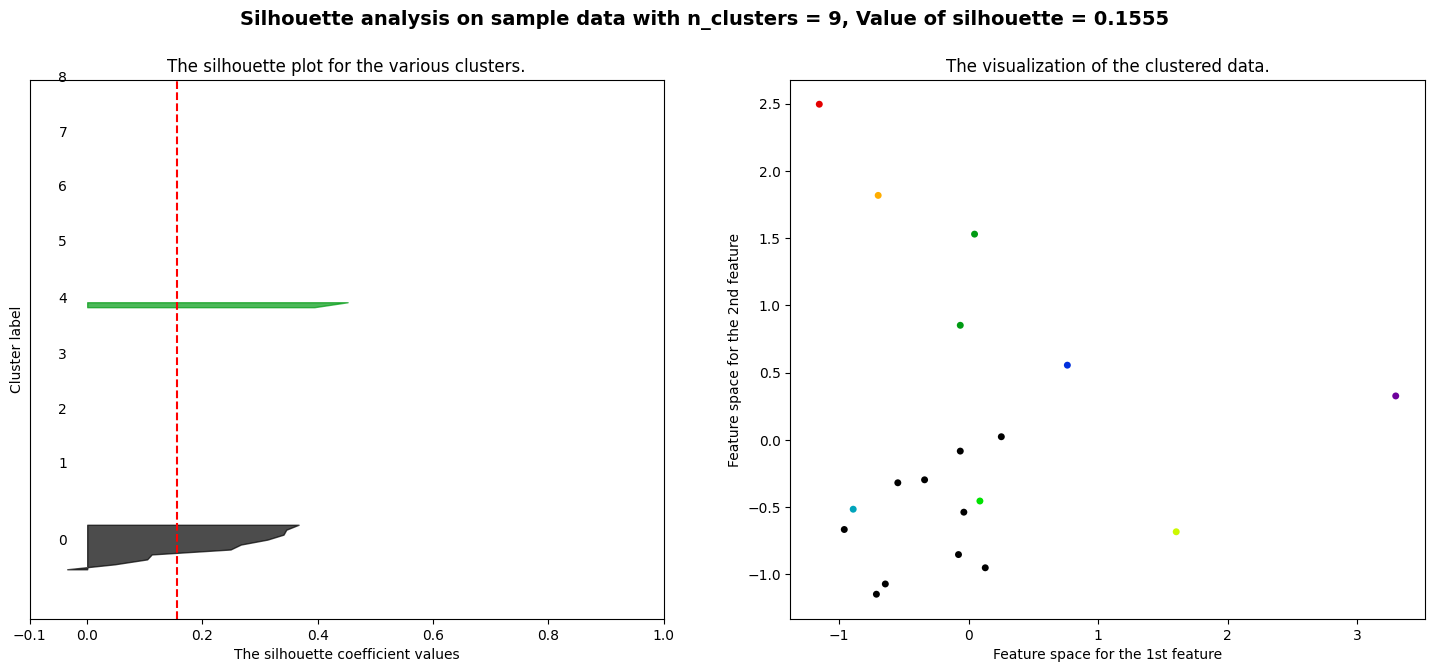

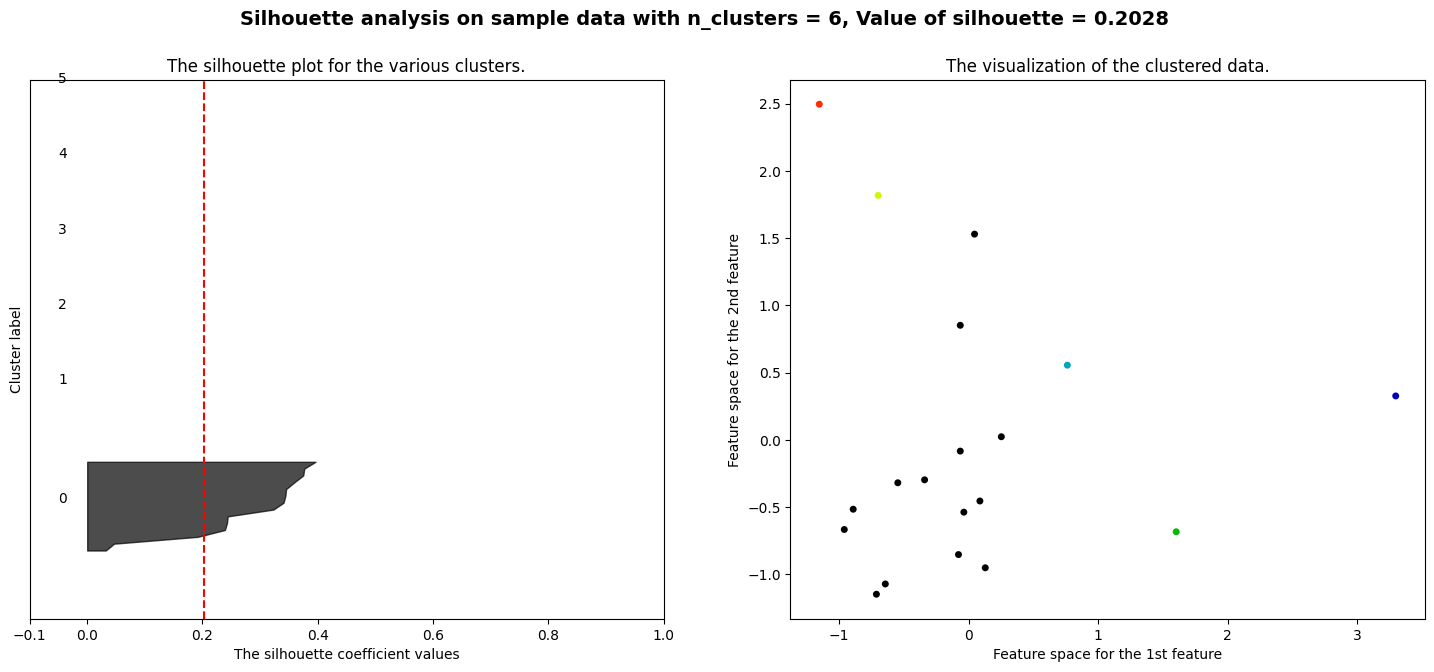

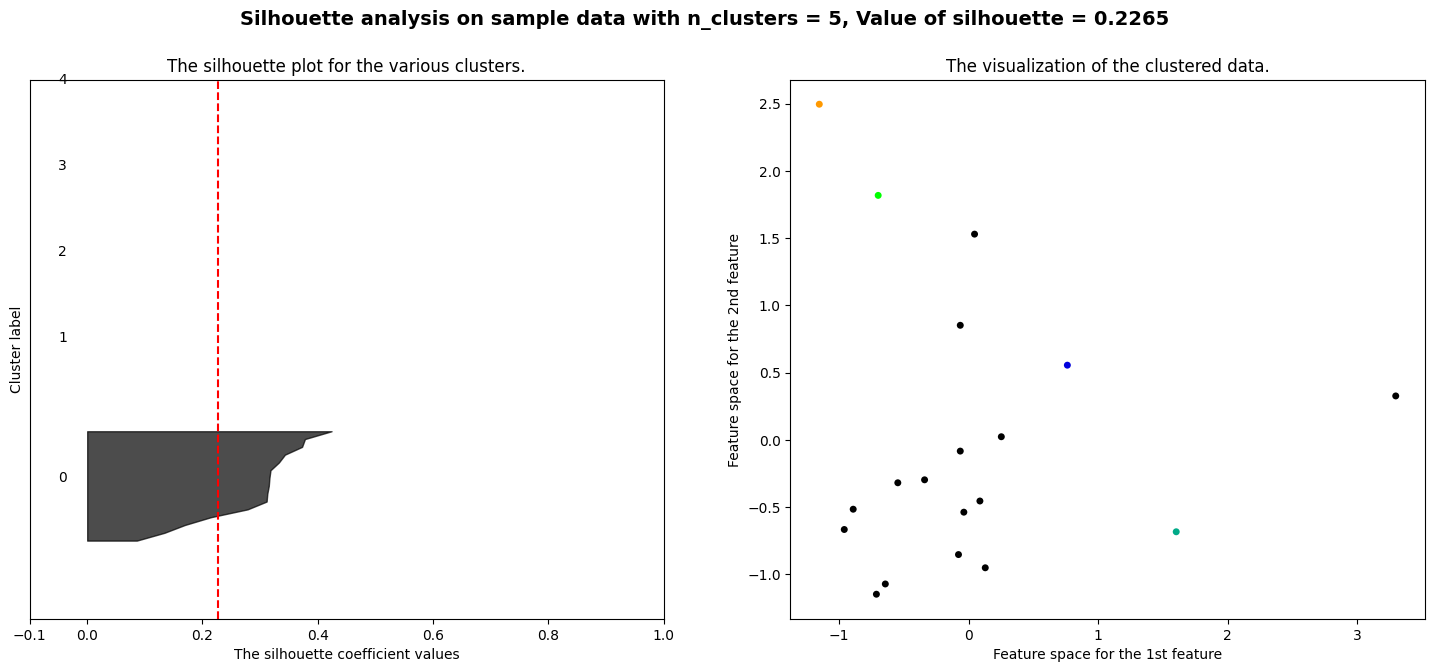

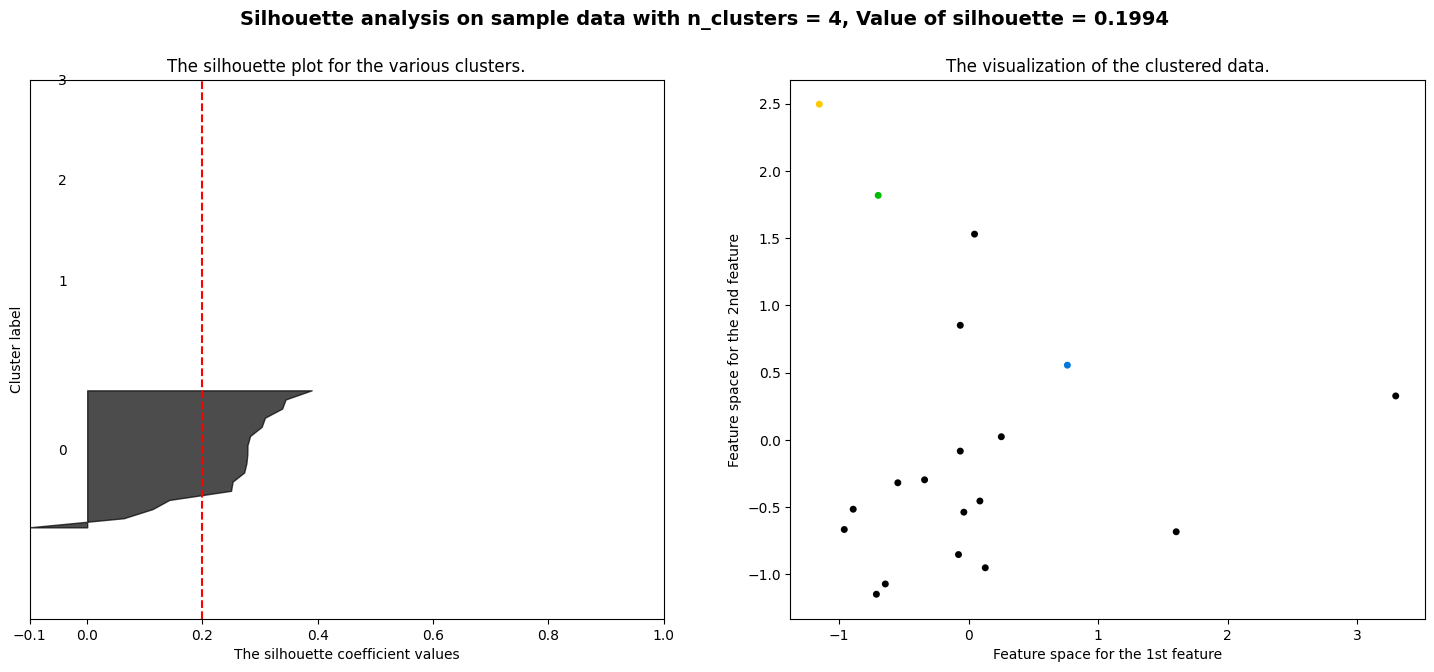

{'Number of\nClusters': dict_keys([9, 6, 5, 4]),
 'Silhouette\nAnalysis': ['0.155', '0.202', '0.226**', '0.199'],
 'Calinski\nHarabasz': ['4.855**', '3.433', '3.179', '2.444'],
 'Davies\nBoulding': ['0.527*', '0.490**', '0.506*', '0.565']}

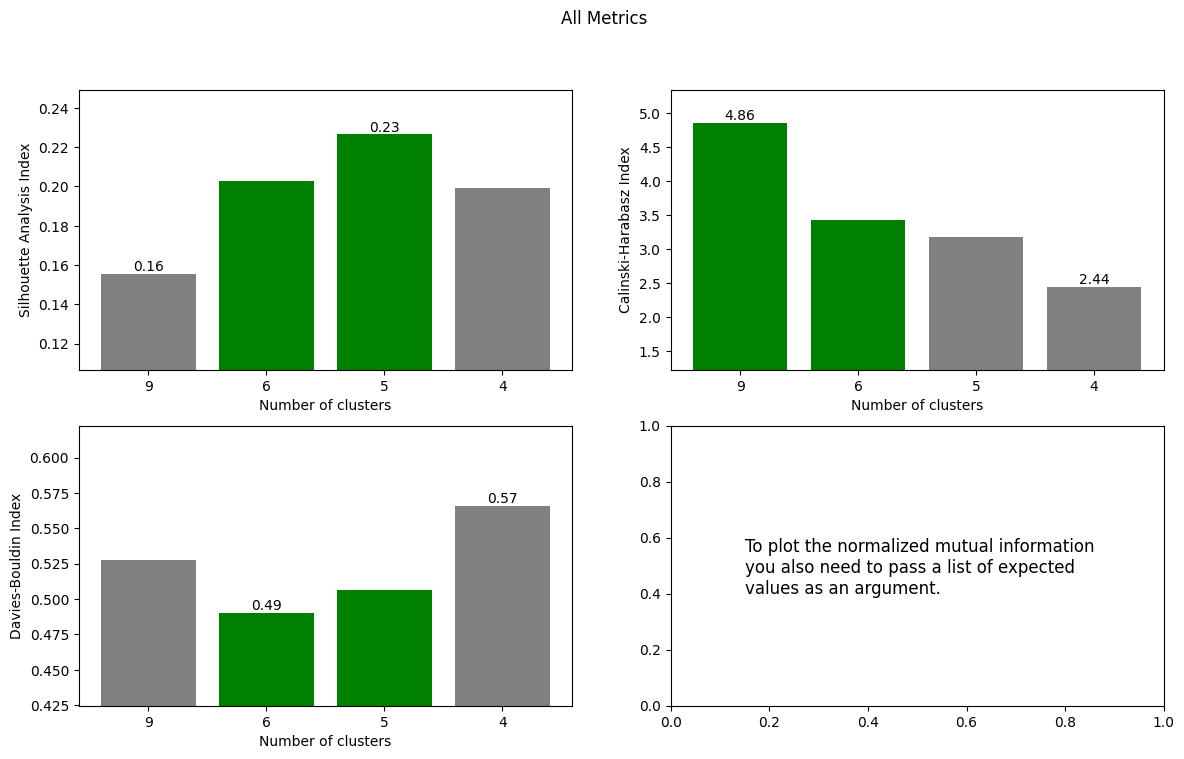

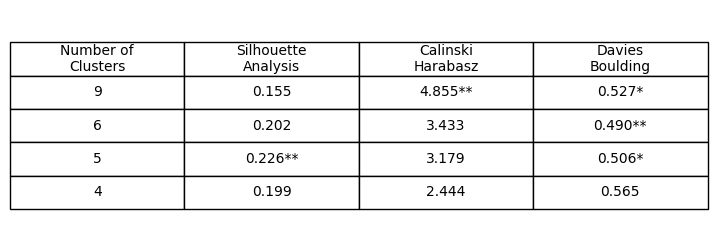

In [ ]:
mtr.print_metrics(clusters_list_abril, df_abril_values)

## Métricas de Outubro

In [ ]:
clusters_list_outubro = []
for eps in range(6, 12):
  dbscan = DBSCAN(eps=eps, min_samples=1)
  dbscan.fit(df_outubro_values)
  rotulos = dbscan.labels_
  clusters_list_outubro.append(rotulos)
clusters_list_outubro = np.array(clusters_list_outubro)
clusters_list_outubro

array([[0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 4, 5, 0, 0, 0, 0, 0, 0, 6, 7],
       [0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 4, 5, 0, 0, 0, 0, 0, 0, 6, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 4],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
clusters_list_outubro = [clusters_list_outubro[0], clusters_list_outubro[2], clusters_list_outubro[3], clusters_list_outubro[5]]
clusters_list_outubro

[array([0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 4, 5, 0, 0, 0, 0, 0, 0, 6, 7]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 4]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0])]

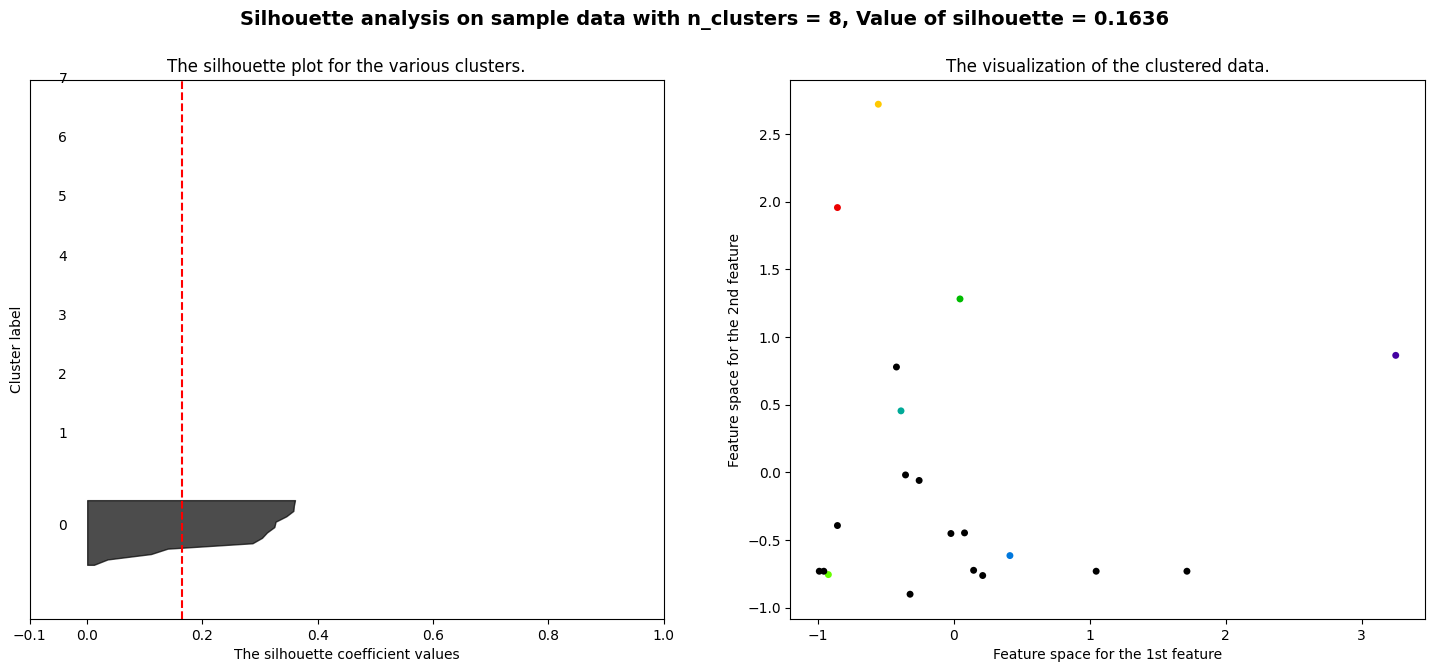

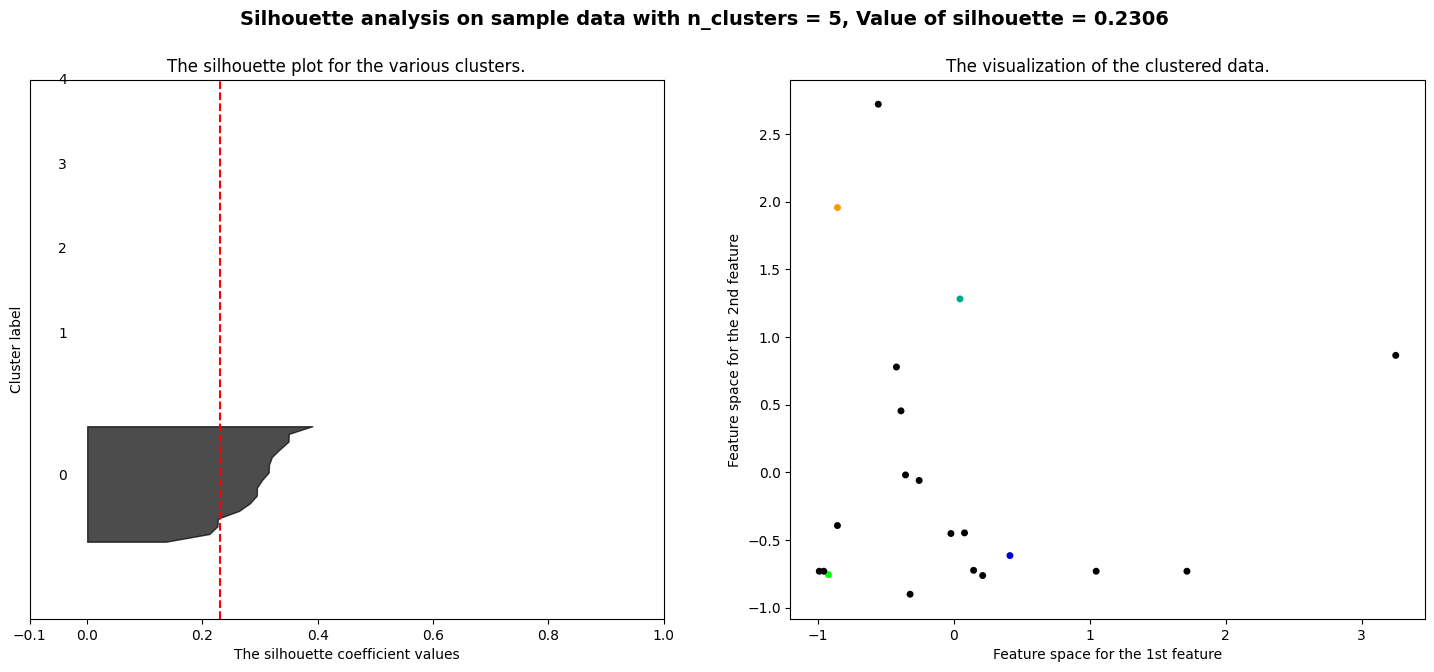

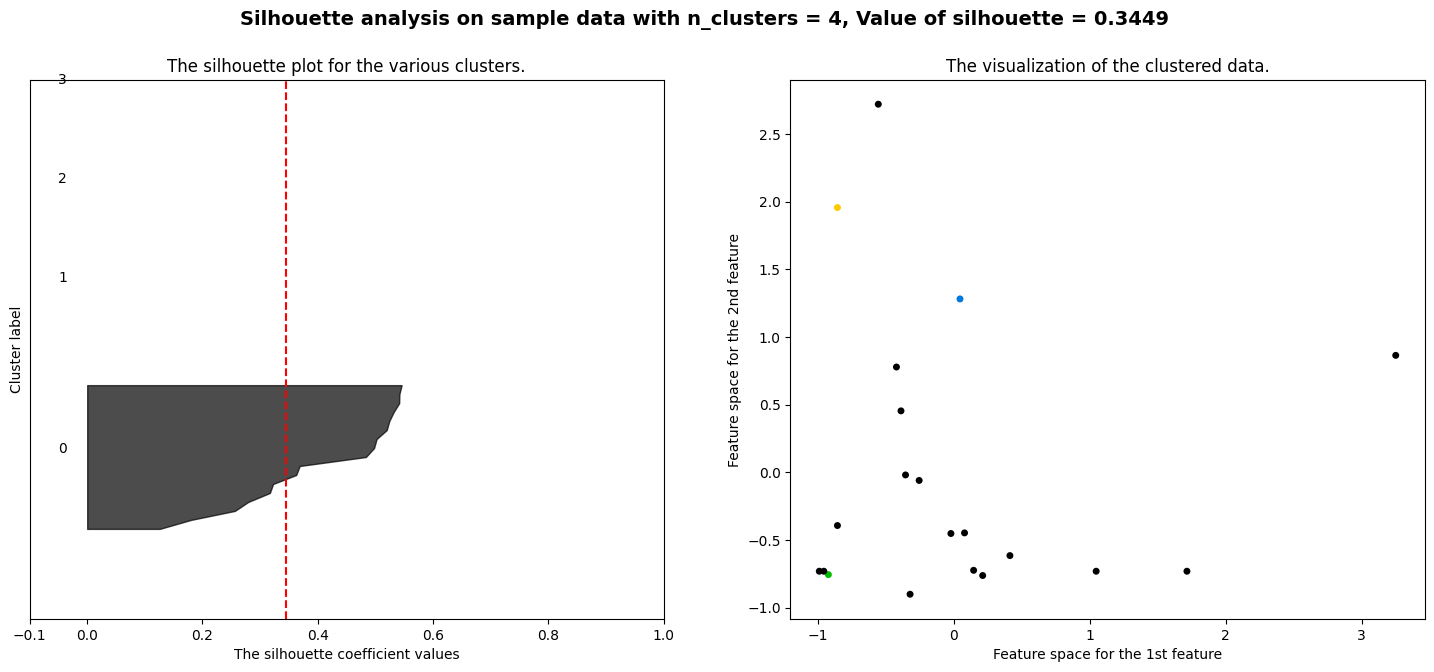

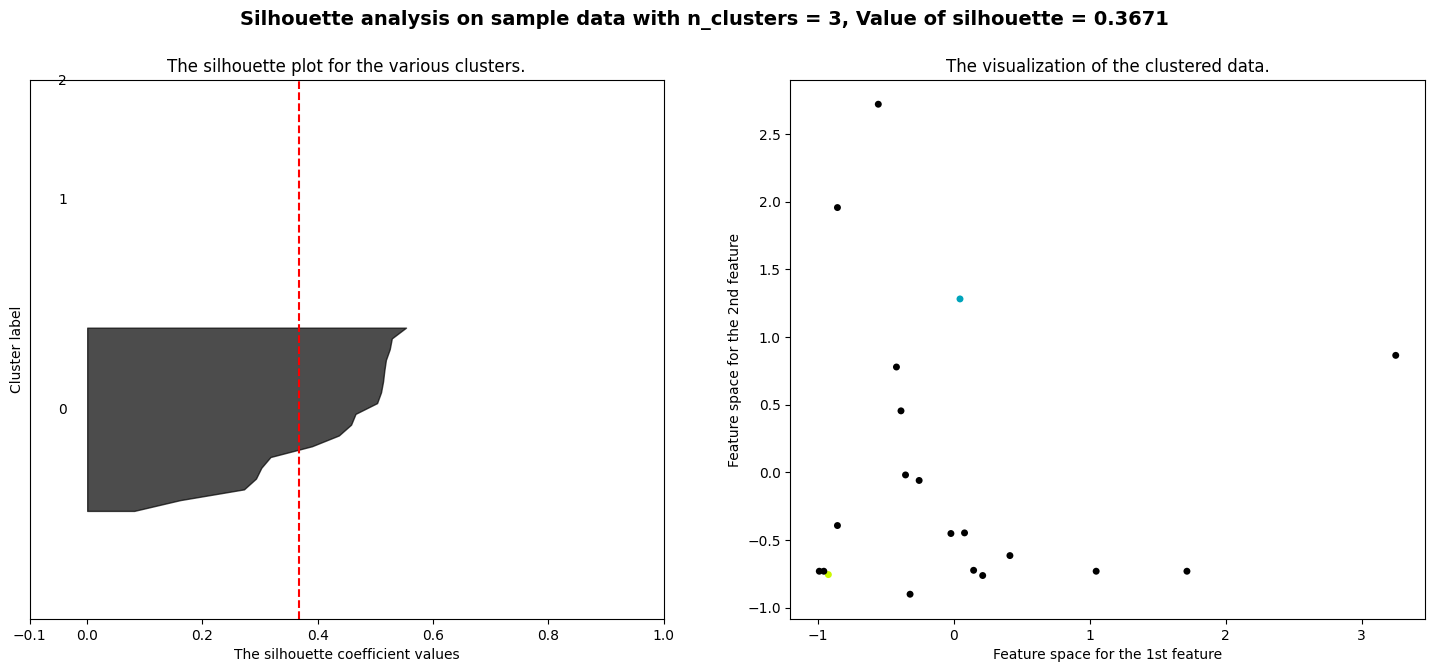

{'Number of\nClusters': dict_keys([8, 5, 4, 3]),
 'Silhouette\nAnalysis': ['0.163', '0.230', '0.344*', '0.367**'],
 'Calinski\nHarabasz': ['5.386**', '4.835', '5.118*', '4.627'],
 'Davies\nBoulding': ['0.432*', '0.447', '0.400**', '0.416*']}

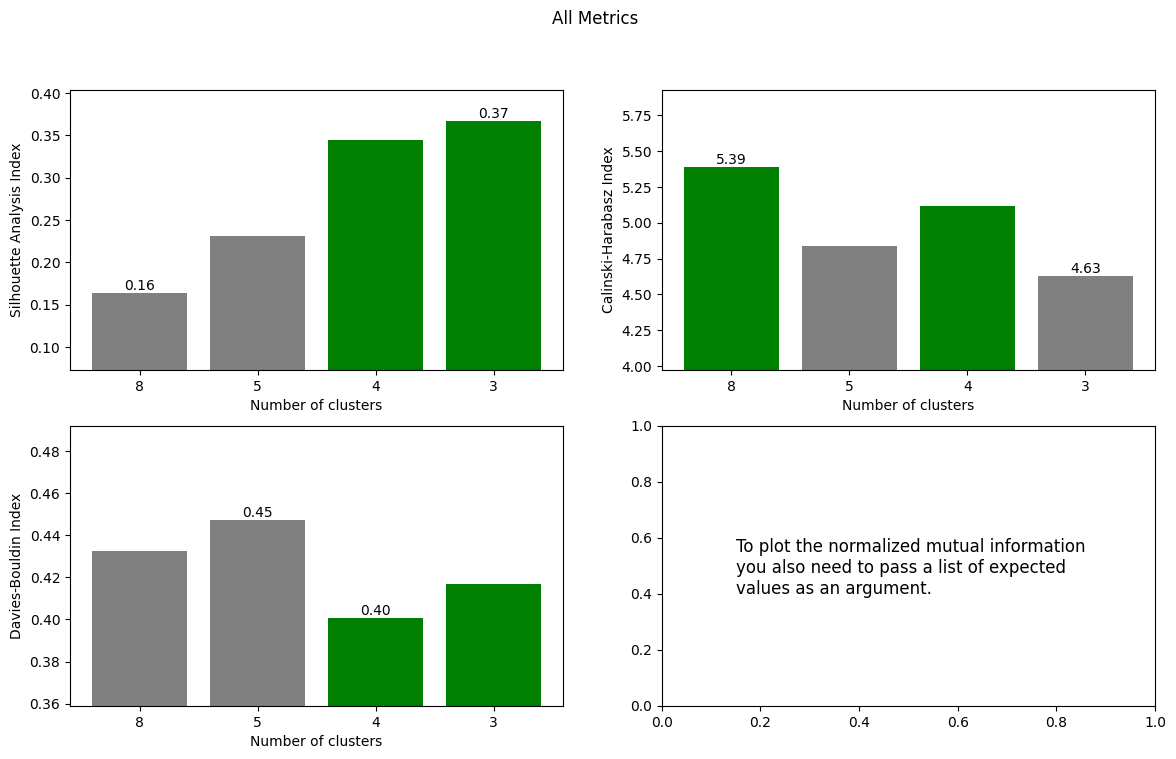

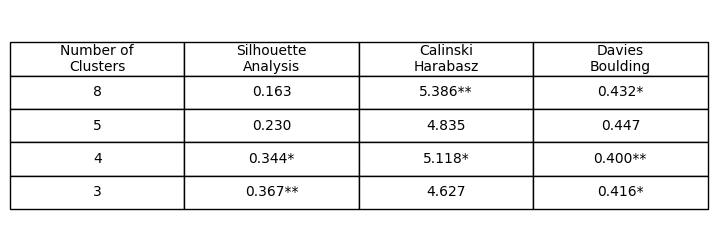

In [ ]:
mtr.print_metrics(clusters_list_outubro, df_outubro_values)

# Gráficos
Nessa etapa, foi impresso um mapa da região com pontos coloridos que representam os poços de coleta dos dados. As cores representam os rótulos resultantes do agrupamento feito pelo algoritmo DBSCAN.

Para cada período análisado, serão impressos os 5 mapas, cada mapa com um número de grupo.

## Mapas para o a coleta de Abril




In [ ]:
for eps in range(6,10):
  # Criar um mapa usando folium
  mapa = folium.Map(location=coordenadas_abril[0], zoom_start=17)

  # Plotar os pontos no mapa com cores correspondentes aos rótulos
  cores = ['red', 'blue', 'green', 'orange', 'yellow', 'purple', 'black', 'pink', 'white']  # Cores para cada rótulo
  for i in range(df_abril.shape[0]):
      cor = cores[clusters_list_abril[eps-6, i]]
      folium.CircleMarker(location=coordenadas_abril[i], color=cor, fill=True, fill_color=cor, radius=8, tooltip=(df_abril.iloc[i, 0], df_abril.iloc[i, 1])).add_to(mapa)

  # Exibir o mapa
  mapa.save(f"/content/drive/Shareddrives/datasci4water/IG/data/interim/maps/dbscan_abril_com_coord_eps_{eps}.html")


## Mapas para o a coleta de Outubro


In [ ]:
for eps in range(6,10):
  # Criar um mapa usando folium
  mapa = folium.Map(location=coordenadas_outubro[0], zoom_start=17)

  # Plotar os pontos no mapa com cores correspondentes aos rótulos
  cores = ['red', 'blue', 'green', 'orange', 'yellow', 'purple', 'black', 'pink', 'white']  # Cores para cada rótulo
  for i in range(df_outubro.shape[0]):
      cor = cores[clusters_list_outubro[eps-6, i]]
      folium.CircleMarker(location=coordenadas_outubro[i], color=cor, fill=True, fill_color=cor, radius=8, tooltip=(df_outubro.iloc[i, 0], df_outubro.iloc[i, 1])).add_to(mapa)

  # Exibir o mapa
  mapa.save(f"/content/drive/Shareddrives/datasci4water/IG/data/interim/maps/dbscan_outubro_com_coord_eps_{eps}.html")
